# Below is the last successful running code

In [1]:
import Random
using Plots
using Statistics

const seed = Random.seed!(42)  # Fixing the overall seed for reproducible results by running the entire script.


function get_positive_energies()
    pos_ΔE = sort(unique(Int8[2*mid*(left+right+above+below) for mid=[-1, 1], left=[-1, 1], right=[-1, 1],
                    above=[-1, 1], below=[-1, 1] if 2*mid*(left + right + above + below) > 0]))
    return pos_ΔE
end


function get_acceptance_probabilities(beta::Float64, pos_ΔE::Array{Int8, 1})::Array{Float64, 1}
    acceptance_probabilities::Array{Float64, 1} = Float64[exp(-beta*ΔE) for ΔE in pos_ΔE]
    return acceptance_probabilities
end


function mc_step!(state::Array{Int8, 1}, pos_ΔE::Array{Int8, 1}, acceptance_probabilities::Array{Float64, 1}, skip::Int32)
    length = 30
    spins = length^2
    rand_sites = rand(seed, 1:spins, skip*spins)
    for site in rand_sites
        ΔE = 2 * state[site] * (state[mod1(site+length, spins)] + state[mod1(site-length, spins)] + 
            state[mod1(site+1, length) + ((site-1)÷length)*length] + 
            state[mod1(site-1, length) + ((site-1)÷length)*length])
        if ΔE > 0 && rand(seed) > acceptance_probabilities[findfirst(isequal(ΔE), pos_ΔE)]
            continue
        end
        state[site] *= -1
    end
    return
end


function ising2d(beta_values::Array{Float64, 1}, length::Int32, configurations::Int32, skip::Int32)
    spins::Int32 = length^2
    pos_ΔE::Array{Int8, 1} = get_positive_energies()
    mean_magnetization = Float64[]
    start = time()
    for beta in beta_values
        start2 = time()
        state = -ones(Int8, spins)
        acceptance_probabilities::Array{Float64, 1} = get_acceptance_probabilities(beta, pos_ΔE)
        magnetisation = sum(state)/spins  # Calculate the magnetisation apart so that it is immutable.
        magnetisation_values = Float64[magnetisation]
        for _ in 1:configurations
            mc_step!(state, pos_ΔE, acceptance_probabilities, skip)
            magnetisation = sum(state)/spins
            push!(magnetisation_values, magnetisation)
        end
        mean_value = abs(mean(magnetisation_values))
        push!(mean_magnetization, mean_value)

        elapsed = time() - start2
        println("β = ", beta, " with time = ", elapsed)
    end
    elapsed = time() - start
    println("Total time = ", elapsed)
    return mean_magnetization
end

ising2d (generic function with 1 method)

β = 0.0 with time = 1.8191308975219727
β = 

0.02210526315789474 with time = 1.9033918380737305
β = 0.04421052631578948 with time = 2.010439157485962
β = 0.06631578947368422 with time = 2.0954129695892334
β = 0.08842105263157896 with time = 2.200958013534546
β = 0.11052631578947368 with time = 2.2988760471343994
β = 0.13263157894736843 with time = 2.3888309001922607
β = 0.15473684210526314 with time = 2.4703011512756348
β = 0.1768421052631579 with time = 2.558769941329956
β = 0.19894736842105265 with time = 2.601452112197876
β = 0.22105263157894736 with time = 2.6155638694763184
β = 0.2431578947368421 with time = 2.643308162689209
β = 0.26526315789473687 with time = 2.6373910903930664
β = 0.28736842105263155 with time = 2.6088271141052246
β = 0.3094736842105263 with time = 2.6044459342956543
β = 0.33157894736842103 with time = 2.584716796875
β = 0.3536842105263158 with time = 2.561189889907837
β = 0.37578947368421056 with time = 2.4916510581970215
β = 0.3978947368421053 with time = 2.3582260608673096
β = 0.42 with time = 2.176103

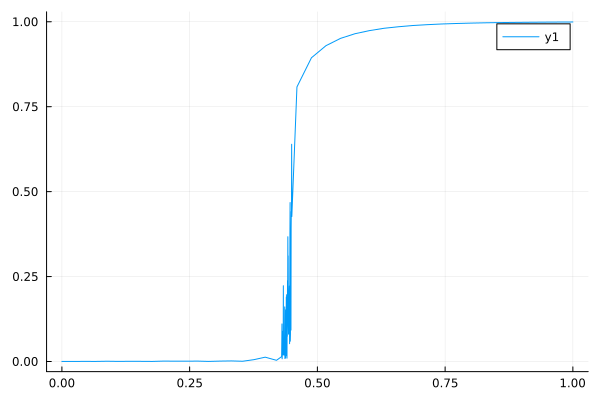

In [6]:
a = Float64[i/100 for i in range(0, 42, length=20)]
c = Float64[i/100 for i in range(46, 100, length=20)]
b = Float64[i/100 for i in range(43, 45, length=60)]
beta_values = Float64[a; b; c]

const length::Int32 =30
const configurations ::Int32 = 4000
const skip::Int32 = 40

mean_magnetization = ising2d(beta_values, length, configurations, skip)

plot(beta_values, mean_magnetization)

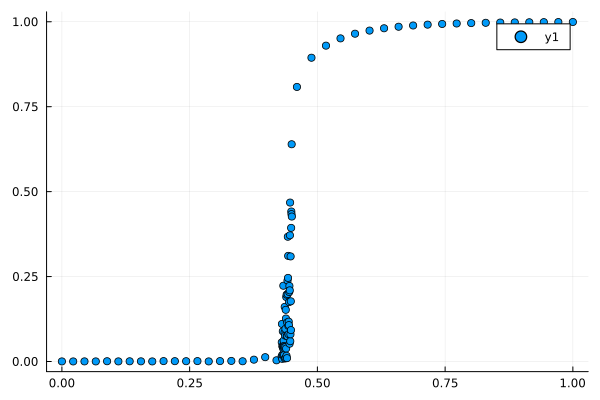

In [11]:
plot(beta_values, mean_magnetization, seriestype = :scatter)